In [12]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
import os
import sys
import cv2
import numpy as np
import os

In [14]:
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
from pipeline import Pipeline

### Set up directory and sample path

In [15]:
# Define path for gallery images
gallery_index_path = "..\\storage\\multi_image_gallery"

# Define path for sample test
probe_folder_path = "..\\simclr_resources\\probe"
sample_probe_name = "Ian_Thorpe\\Ian_Thorpe_0002.jpg"
sample_probe_path = os.path.join(probe_folder_path, sample_probe_name)
sample_probe = Image.open(sample_probe_path)

### Model 1 - VGGFace2

In [34]:
# Initialized pipeline for pre-trained model VGGFace2
pretained1 = 'vggface2'
pipeline1 = Pipeline(pretained1, index_type='HNSW', metric='cosine')

c:\Users\gsjsc\anaconda3\envs\en605645\Lib\site-packages\facenet_pytorch\models\inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

In [35]:
# Define path for faiss index and metadata saving folders
faiss_index_path1 = os.path.join('..', 'storage', f'catalog_{pretained1}')
metadata_path1 = os.path.join('..', 'storage', f'catalog_{pretained1}')

# Precompute and save faiss index and metadata for the model
pipeline1.precompute_and_save(gallery_index_path, faiss_index_path1, metadata_path1)

Precomputed and saved embeddings for the gallery images.


In [36]:
# Load FAISS index and metadata for the model
faiss_index_path1_load = os.path.join(faiss_index_path1, 'faiss_index.bin')
metadata_path1_load = os.path.join(metadata_path1, 'metadata.pkl')

pipeline1.index.load(faiss_index_path1_load, metadata_path1_load)

In [37]:
# Test case for one sample probe
print(f"Under model {pretained1}, for probe {sample_probe_name}, The top 5 nearest neighbors are:\n")
results1 = pipeline1.search_gallery(sample_probe, 5)
for result in results1:
    print(f"Index: {result['index']}, Distance: {result['distance']:.4f}, Name: {result['name']}, Filename: {result['filename']}")

Under model vggface2, for probe Ian_Thorpe\Ian_Thorpe_0002.jpg, The top 5 nearest neighbors are:

Index: 872, Distance: 0.3585, Name: ['Ian_Thorpe'], Filename: ['Ian_Thorpe_0006.jpg']
Index: 1732, Distance: 0.3244, Name: ['Oscar_De_La_Hoya'], Filename: ['Oscar_De_La_Hoya_0003.jpg']
Index: 871, Distance: 0.2565, Name: ['Ian_Thorpe'], Filename: ['Ian_Thorpe_0005.jpg']
Index: 1716, Distance: 0.2039, Name: ['Noah_Wyle'], Filename: ['Noah_Wyle_0001.jpg']
Index: 1500, Distance: 0.1951, Name: ['Mark_Dacey'], Filename: ['Mark_Dacey_0001.jpg']


### Model 2 - casia-webface

In [38]:
# Initialized pipeline for pre-trained model casia-webface
pretained2 = 'casia-webface'
pipeline2 = Pipeline(pretained2, index_type='brute_force', metric='euclidean')

In [39]:
# Define path for gallery images, faiss index and metadata saving folders
faiss_index_path2 = os.path.join('..', 'storage', f'catalog_{pretained2}')
metadata_path2 = os.path.join('..', 'storage', f'catalog_{pretained2}')

# Precompute and save faiss index and metadata for the model
pipeline2.precompute_and_save(gallery_index_path, faiss_index_path2, metadata_path2)

Precomputed and saved embeddings for the gallery images.


In [40]:
# Load FAISS index and metadata for the model
faiss_index_path2_load = os.path.join(faiss_index_path2, 'faiss_index.bin')
metadata_path2_load = os.path.join(metadata_path2, 'metadata.pkl')

pipeline2.index.load(faiss_index_path2_load, metadata_path2_load)

In [41]:
# Check result for the test case
print(f"Under model {pretained2}, for probe {sample_probe_name}, The top 5 nearest neighbors are:\n")
results2 = pipeline2.search_gallery(sample_probe, 5)
for result in results2:
    print(f"Index: {result['index']}, Distance: {result['distance']:.4f}, Name: {result['name']}, Filename: {result['filename']}")

Under model casia-webface, for probe Ian_Thorpe\Ian_Thorpe_0002.jpg, The top 5 nearest neighbors are:

Index: 88, Distance: 0.2395, Name: ['Alvaro_Uribe'], Filename: ['Alvaro_Uribe_0005.jpg']
Index: 642, Distance: 0.2857, Name: ['Gary_Williams'], Filename: ['Gary_Williams_0001.jpg']
Index: 1325, Distance: 0.2909, Name: ['Kim_Ryong-sung'], Filename: ['Kim_Ryong-sung_0001.jpg']
Index: 1150, Distance: 0.2940, Name: ['John_McEnroe'], Filename: ['John_McEnroe_0001.jpg']
Index: 1595, Distance: 0.2980, Name: ['Michael_Phelps'], Filename: ['Michael_Phelps_0003.jpg']


## Model Performance Evaluation

### 1. Mean Reciprocal Rank

In [5]:
# Function to loop over all probes and calculate mean reciprocal rank
def calculate_mrr(probe_folder_path, pipeline, k=5):

    reciprocal_rank = 0
    total_probe = 0

    for probe_name in os.listdir(probe_folder_path):
        probe_person_folder = os.path.join(probe_folder_path, probe_name)

        for probe_file_name in os.listdir(probe_person_folder):
            if probe_file_name.endswith(('.jpg', '.png', '.jpeg')) and not probe_file_name.startswith('._'):
                image_path = os.path.join(probe_person_folder, probe_file_name)
                total_probe += 1

                try:
                    with Image.open(image_path) as img:

                        # 1. Get the top neighbors for the probe
                        results = pipeline.search_gallery(img, k)

                        #2. Check if the probe name are in the returned relevant items
                        names = [result['name'] for result in results]
                        for i in range(k):
                            if probe_name == names[i][0]:
                                reciprocal_rank += 1/(i+1)
                                break

                except PIL.UnidentifiedImageError:
                    print(f"Skipping file {image_path}: UnidentifiedImageError")
    
    mrr = reciprocal_rank/total_probe * 100
    print(f"Mean Recriprocal Rank: {mrr:.2f}%")
    return mrr

In [42]:
print(f"For model {pretained1}:")
calculate_mrr(probe_folder_path, pipeline1, k=5)

For model vggface2:
Mean Recriprocal Rank: 55.59%


55.588922255588905

In [43]:
print(f"For model {pretained2}:")
calculate_mrr(probe_folder_path, pipeline2, k=5)

For model casia-webface:
Mean Recriprocal Rank: 11.77%


11.765098431765098

### 2. Precision@k & mAP

In [6]:
# Function to loop over all probes, calculate precision@k and Mean Average Precision
def precision_map_k(probe_folder_path, pipeline, k=5):

    total_precision = 0
    total_probe = 0
    total_map = 0

    for probe_name in os.listdir(probe_folder_path):
        probe_person_folder = os.path.join(probe_folder_path, probe_name)

        for probe_file_name in os.listdir(probe_person_folder):
            if probe_file_name.endswith(('.jpg', '.png', '.jpeg')) and not probe_file_name.startswith('._'):
                image_path = os.path.join(probe_person_folder, probe_file_name)
                total_probe += 1

                try:
                    with Image.open(image_path) as img:

                        # 1. Get the top neighbors for the probe
                        results = pipeline.search_gallery(img, k)

                        # 2. Check if the probe name are in the returned relevant items
                        relevant = 0
                        numerator = 0

                        names = [result['name'] for result in results]
                        for i in range(k):
                            if probe_name == names[i][0]:
                                relevant += 1
                        # 3. Add each match's reciprocal rank to numerator
                                numerator += relevant/(i+1)
                        
                        # 4. Calculate precision
                        precision = relevant/k
                        total_precision += precision

                        #5. Calculate mAP
                        map = numerator/relevant if relevant !=0 else 0
                        total_map += map

                except PIL.UnidentifiedImageError:
                    print(f"Skipping file {image_path}: UnidentifiedImageError")
    
    precision_k = total_precision/total_probe
    mAP = total_map/total_probe
    print(f"Precision@k when k = {k}: {precision_k:.4f}")
    print(f"mAP when k = {k}: {mAP:.4f}")
    
    return precision_k, mAP

In [44]:
print(f"For model {pretained1}:")
precision_map_k(probe_folder_path, pipeline1, k=5)

For model vggface2:
Precision@k when k = 5: 0.2028
mAP when k = 5: 0.5451


(0.20280280280280208, 0.5450617283950615)

In [45]:
print(f"For model {pretained2}:")
precision_map_k(probe_folder_path, pipeline2, k=5)

For model casia-webface:
Precision@k when k = 5: 0.0374
mAP when k = 5: 0.1161


(0.03743743743743744, 0.11608552997441884)

## Model Performance Under Different Specifications

In [8]:
pretrained_models = ['casia-webface', 'vggface2']
index_types = ['IVF', 'brute_force', 'HNSW']
metrics = ['minkowski', 'cosine'] 
k = 5

In [9]:
# Collect mrr, precision@k, mAP data for models under different specifications
# Initialize collections for results
results = {
    'model': [],
    'index_type': [],
    'metric': [],
    'k': [],
    'mrr': [],
    'precision@k': [],
    'mAP': []
}


for pretrained in pretrained_models:
    for index in index_types:
        for metric in metrics:
            for pram_k in range(1, k + 1):
                pipeline = Pipeline(pretrained, index_type=index, metric=metric)

                # Reporting offline metrics for current model
                print(f'\nFor model {pretrained} with index {index}, metric {metric}, and k = {pram_k}:')

                # Precompute and save faiss index and metadata for the model
                pipeline.precompute(gallery_index_path)

                # Calculate mrr
                mrr = calculate_mrr(probe_folder_path, pipeline, k=pram_k)

                # Calculate precision@k and mAP
                precision_k, mAP = precision_map_k(probe_folder_path, pipeline, k=pram_k)

                # Store results in the dictionary
                results['model'].append(pretrained)
                results['index_type'].append(index)
                results['metric'].append(metric)
                results['k'].append(pram_k)
                results['mrr'].append(mrr)
                results['precision@k'].append(precision_k)
                results['mAP'].append(mAP)

                

c:\Users\gsjsc\anaconda3\envs\en605645\Lib\site-packages\facenet_pytorch\models\inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.


For model casia-webface with index IVF, metric minkowski, and k = 1:
Precomputed the gallery images.
Mean Recriprocal Rank: 4.90%
Precision@k when k = 1: 0.0490
mAP when k = 1: 0.0490

For model casia-webface with index IVF, metric minkowski, and k = 2:
Precomputed the gallery images.
Mean Recriprocal Rank: 5.46%
Precision@k when k = 2: 0.0305
mAP when k = 2: 0.0546

For model casia-webface with index IVF, metric minkowski, and k = 3:
Precomputed the gallery images.
Mean Recriprocal Rank: 5.92%
Precision@k when k = 3: 0.0250
mAP when k = 3: 0.0592

For model casia-webface with index IVF, metric minkowski, and k = 4:
Precomputed the gallery images.
Mean Recriprocal Rank: 6.17%
Precision@k when k = 4: 0.0215
mAP when k = 4: 0.0618

For model casia-webface with index IVF, metric minkowski, and k = 5:
Precomputed the gallery images.
Mean Recriprocal Rank: 6.27%
Precision@k when k = 5: 0.0184
mAP when k = 5: 0.0628

For model casia-webface with index IVF, metric cosine, and k = 1:
Precompu

In [10]:
# Convert the results dictionary to a DataFrame for easy viewing and analysis
import pandas as pd
results_df = pd.DataFrame(results)
print("\nTesting Results:")
print(results_df)

performance_data_path = "..\\notebooks\\optimized_model_evaluation_results.csv"
# Save results to a CSV file
results_df.to_csv(performance_data_path, index=False)


Testing Results:
            model   index_type     metric  k        mrr  precision@k       mAP
0   casia-webface          IVF  minkowski  1   4.904905     0.049049  0.049049
1   casia-webface          IVF  minkowski  2   5.455455     0.030531  0.054555
2   casia-webface          IVF  minkowski  3   5.922589     0.025025  0.059226
3   casia-webface          IVF  minkowski  4   6.172840     0.021522  0.061812
4   casia-webface          IVF  minkowski  5   6.272940     0.018418  0.062846
5   casia-webface          IVF     cosine  1   4.904905     0.049049  0.049049
6   casia-webface          IVF     cosine  2   5.455455     0.030531  0.054555
7   casia-webface          IVF     cosine  3   5.922589     0.025025  0.059226
8   casia-webface          IVF     cosine  4   6.172840     0.021522  0.061812
9   casia-webface          IVF     cosine  5   6.272940     0.018418  0.062846
10  casia-webface  brute_force  minkowski  1   9.309309     0.093093  0.093093
11  casia-webface  brute_force  mi

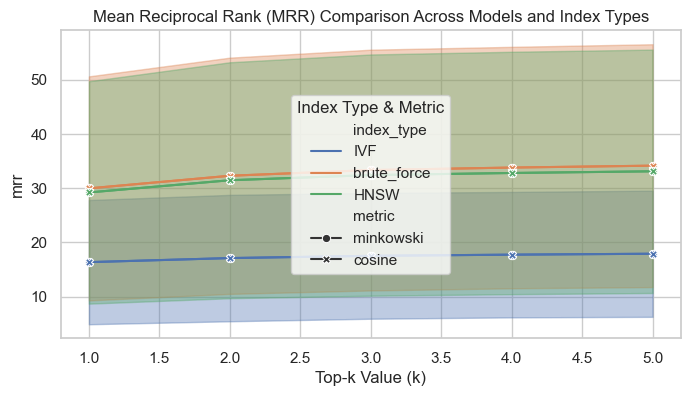

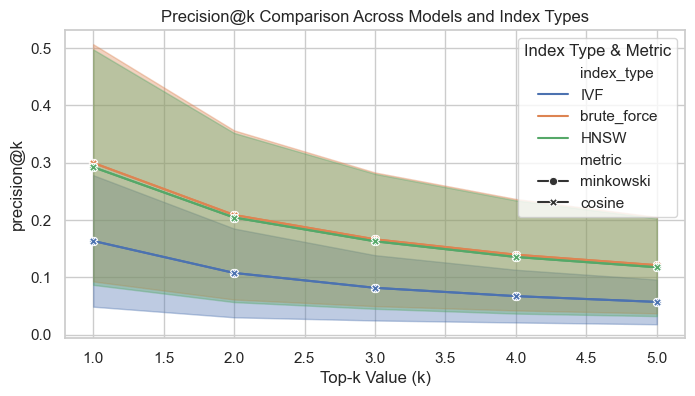

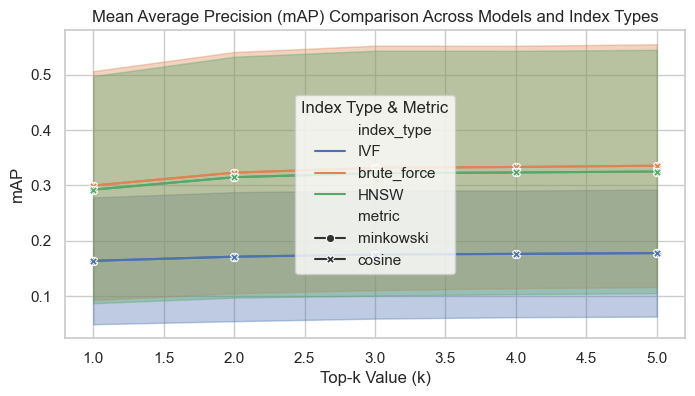

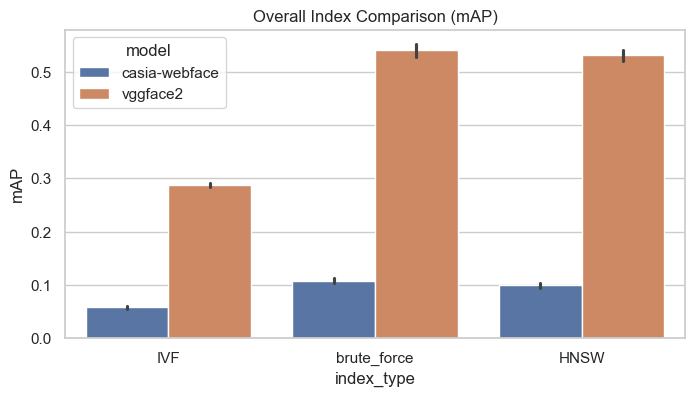

In [68]:
import seaborn as sns

# Set a style
sns.set(style="whitegrid")

# Function to plot metric comparison for MRR, Precision@k, and mAP
def plot_metrics(data, metric, title):
    plt.figure(figsize=(8,4))
    sns.lineplot(
        data=data, x="k", y=metric, hue="index_type", style="metric",
        markers=True, dashes=False
    )
    plt.title(title)
    plt.xlabel("Top-k Value (k)")
    plt.ylabel(metric)
    plt.legend(title="Index Type & Metric")
    plt.show()

# Plot MRR
plot_metrics(results_df, "mrr", "Mean Reciprocal Rank (MRR) Comparison Across Models and Index Types")

# Plot Precision@k
plot_metrics(results_df, "precision@k", "Precision@k Comparison Across Models and Index Types")

# Plot mAP
plot_metrics(results_df, "mAP", "Mean Average Precision (mAP) Comparison Across Models and Index Types")

# Plot overall model comparison for mrr, precision@k, and mAP
plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="index_type", y="mAP", hue="model")
plt.title("Overall Index Comparison (mAP)")
plt.show()

From above, the choice on metric (minkowski or cosine) doesn't have an effect on model or index choosing. I also tested on metric euclidean and found the same. Therefore, I decided to test other indexes for model vggface2 with metric = "cosine" and k = 5.

In [73]:
index_types_2 = ['brute_force', 'HNSW', 'IVF', 'IVFSQ']
index_types_2 = ['brute_force', 'HNSW']

In [74]:
import time
# Collect latency, mrr, precision@k, mAP data for models under different specifications
# Initialize collections for results
results_2 = {
    'model': [],
    'index_type': [],
    'metric': [],
    'k': [],
    'mrr': [],
    'precision@k': [],
    'mAP': [],
    'latency': []
}

for index in index_types_2:
    pipeline = Pipeline('vggface2', index_type=index, metric='cosine')

    # Reporting offline metrics for current model
    print(f'\nFor model {pretrained} with index {index}, metric {metric}, and k = 5:')

    # Precompute and save faiss index and metadata for the model
    pipeline.precompute(gallery_index_path)

    # Measure start time for the evaluation
    start_time = time.time()

    # Calculate mrr
    mrr = calculate_mrr(probe_folder_path, pipeline, k=5)

    # Calculate precision@k and mAP
    precision_k, mAP = precision_map_k(probe_folder_path, pipeline, k=5)

    # Measure end time and calculate latency
    end_time = time.time()
    latency = end_time - start_time

    # Store results in the dictionary
    results_2['model'].append('vggface2')
    results_2['index_type'].append(index)
    results_2['metric'].append('cosine')
    results_2['k'].append(5)
    results_2['mrr'].append(mrr)
    results_2['precision@k'].append(precision_k)
    results_2['mAP'].append(mAP)
    results_2['latency'].append(latency)

    print(f'Latency for evaluation: {latency:.2f} seconds')

c:\Users\gsjsc\anaconda3\envs\en605645\Lib\site-packages\facenet_pytorch\models\inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.


For model vggface2 with index IVF, metric cosine, and k = 5:
Precomputed the gallery images.
Mean Recriprocal Rank: 29.56%
Precision@k when k = 5: 0.0963
mAP when k = 5: 0.2924
Latency for evaluation: 73.63 seconds

For model vggface2 with index brute_force, metric cosine, and k = 5:
Precomputed the gallery images.
Mean Recriprocal Rank: 56.58%
Precision@k when k = 5: 0.2054
mAP when k = 5: 0.5551
Latency for evaluation: 72.91 seconds

For model vggface2 with index HNSW, metric cosine, and k = 5:
Precomputed the gallery images.
Mean Recriprocal Rank: 55.59%
Precision@k when k = 5: 0.2028
mAP when k = 5: 0.5451
Latency for evaluation: 84.59 seconds

For model vggface2 with index IVFSQ, metric cosine, and k = 5:
Precomputed the gallery images.
Mean Recriprocal Rank: 25.32%
Precision@k when k = 5: 0.0813
mAP when k = 5: 0.2488
Latency for evaluation: 81.78 seconds


In [75]:
results_df_2 = pd.DataFrame(results_2)
print("\nTesting Results:")
print(results_df_2)


Testing Results:
      model   index_type  metric  k        mrr  precision@k       mAP  \
0  vggface2          IVF  cosine  5  29.561228     0.096296  0.292402   
1  vggface2  brute_force  cosine  5  56.578245     0.205405  0.555130   
2  vggface2         HNSW  cosine  5  55.588922     0.202803  0.545062   
3  vggface2        IVFSQ  cosine  5  25.315315     0.081281  0.248831   

     latency  
0  73.625126  
1  72.914512  
2  84.594022  
3  81.781139  


In [76]:
# Append results_df_2 directly to the file
performance_data_path = "..\\notebooks\\optimized_model_evaluation_results.csv"
results_df_2.to_csv(performance_data_path, mode='a', index=False, header=False)

Since indexes 'LSH', 'IVFSQ', 'IVFPQ', 'PQ' do not improve the offline metrics, try test different k starting from 6 TO 10 for model vggface2 with index = 'brute_force' and 'HNSW' and metric = "cosine".

In [26]:
index_types_3 = ['brute_force', 'HNSW']

In [27]:
# Collect mrr, precision@k, mAP data for models under different specifications
# Initialize collections for results
results_3 = {
    'model': [],
    'index_type': [],
    'metric': [],
    'k': [],
    'mrr': [],
    'precision@k': [],
    'mAP': []
}

for index in index_types_3:
    for pram_k in range(6, 11):
        pipeline = Pipeline('vggface2', index_type=index, metric='cosine')

        # Reporting offline metrics for current model
        print(f'\nFor model {pretrained} with index {index}, metric {metric}, and k {pram_k}:')

        # Precompute and save faiss index and metadata for the model
        pipeline.precompute(gallery_index_path)

        # Calculate mrr
        mrr = calculate_mrr(probe_folder_path, pipeline, k=pram_k)

        # Calculate precision@k and mAP
        precision_k, mAP = precision_map_k(probe_folder_path, pipeline, k=pram_k)

        # Store results in the dictionary
        results_3['model'].append('vggface2')
        results_3['index_type'].append(index)
        results_3['metric'].append('cosine')
        results_3['k'].append(pram_k)
        results_3['mrr'].append(mrr)
        results_3['precision@k'].append(precision_k)
        results_3['mAP'].append(mAP)

c:\Users\gsjsc\anaconda3\envs\en605645\Lib\site-packages\facenet_pytorch\models\inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.


For model vggface2 with index brute_force, metric cosine, and k 6:
Precomputed the gallery images.
Mean Recriprocal Rank: 56.71%
Precision@k when k = 6: 0.1830
mAP when k = 6: 0.5512

For model vggface2 with index brute_force, metric cosine, and k 7:
Precomputed the gallery images.
Mean Recriprocal Rank: 56.88%
Precision@k when k = 7: 0.1649
mAP when k = 7: 0.5498

For model vggface2 with index brute_force, metric cosine, and k 8:
Precomputed the gallery images.
Mean Recriprocal Rank: 57.07%
Precision@k when k = 8: 0.1499
mAP when k = 8: 0.5497

For model vggface2 with index brute_force, metric cosine, and k 9:
Precomputed the gallery images.
Mean Recriprocal Rank: 57.16%
Precision@k when k = 9: 0.1376
mAP when k = 9: 0.5481

For model vggface2 with index brute_force, metric cosine, and k 10:
Precomputed the gallery images.
Mean Recriprocal Rank: 57.26%
Precision@k when k = 10: 0.1274
mAP when k = 10: 0.5466

For model vggface2 with index HNSW, metric cosine, and k 6:
Precomputed the 

In [ ]:
# Append results_df_3 directly to the file
results_df_3 = pd.DataFrame(results_3)
print("\nTesting Results:")
print(results_df_3)
results_df_3.to_csv(performance_data_path, mode='a', index=False, header=False)

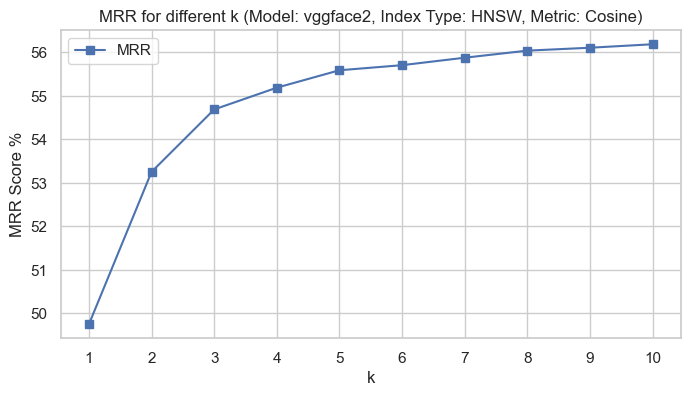

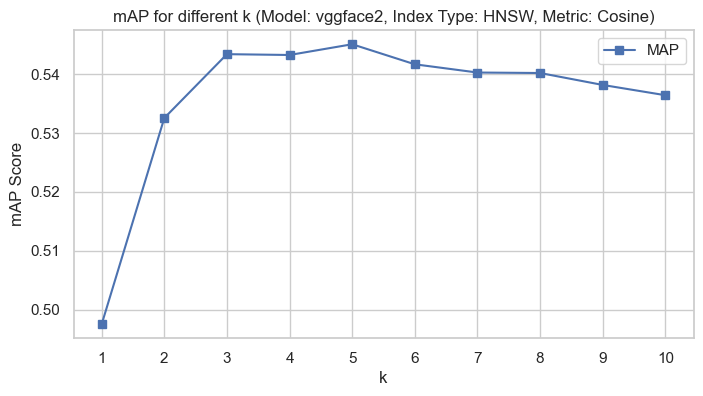

In [78]:
# Load the CSV file
data = pd.read_csv(performance_data_path)

# Filter the data for  for different values of kwhen model=vggface2, index_type=HNSW, and metric=cosine
filtered_data = data[(data['model'] == 'vggface2') & 
                     (data['index_type'] == 'HNSW') & 
                     (data['metric'] == 'cosine')]

# Plot MRR for different values of k
plt.figure(figsize=(8, 4))
plt.plot(filtered_data['k'], filtered_data['mrr'], marker='s', label='MRR')
plt.xlabel('k')
plt.ylabel('MRR Score %')
plt.title('MRR for different k (Model: vggface2, Index Type: HNSW, Metric: Cosine)')
plt.legend()
plt.grid(True)
plt.xticks(filtered_data['k'].unique())
plt.show()

# Plot mAP for different values of k
plt.figure(figsize=(8, 4))
plt.plot(filtered_data['k'], filtered_data['mAP'], marker='s', label='MAP')
plt.xlabel('k')
plt.ylabel('mAP Score')
plt.title('mAP for different k (Model: vggface2, Index Type: HNSW, Metric: Cosine)')
plt.legend()
plt.grid(True)
plt.xticks(filtered_data['k'].unique())
plt.show()

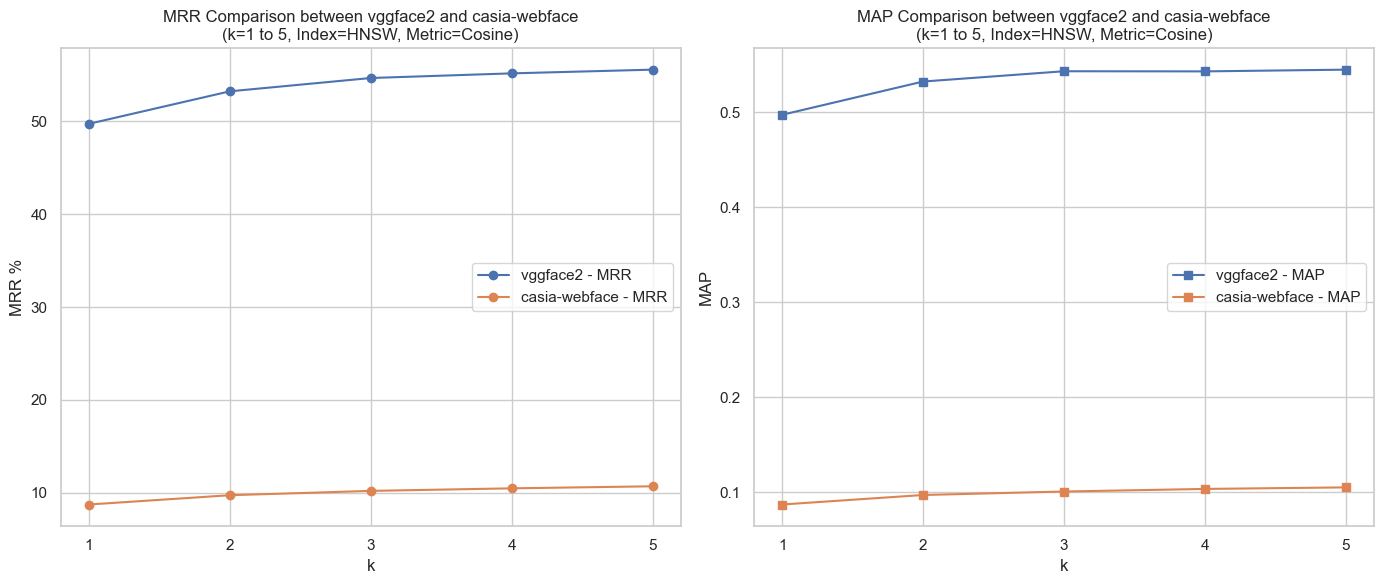

In [62]:
# Filter data for two specific models 'vggface2' and 'casia-webface'
model_1 = 'vggface2'
model_2 = 'casia-webface'
filtered_data = data[(data['model'].isin([model_1, model_2])) & 
                     (data['k'] >= 1) & (data['k'] <= 5) & 
                     (data['index_type'] == 'HNSW') & 
                     (data['metric'] == 'cosine')]

# Plot MRR comparison for the two models across different k values
plt.figure(figsize=(14, 6))

# MRR plot
plt.subplot(1, 2, 1)
for model in [model_1, model_2]:
    model_data = filtered_data[filtered_data['model'] == model]
    plt.plot(model_data['k'], model_data['mrr'], marker='o', label=f'{model} - MRR')
plt.xlabel('k')
plt.ylabel('MRR %')
plt.title(f'MRR Comparison between {model_1} and {model_2}\n(k=1 to 5, Index=HNSW, Metric=Cosine)')
plt.legend()
plt.xticks(filtered_data['k'].unique())
plt.grid(True)

# MAP plot
plt.subplot(1, 2, 2)
for model in [model_1, model_2]:
    model_data = filtered_data[filtered_data['model'] == model]
    plt.plot(model_data['k'], model_data['mAP'], marker='s', label=f'{model} - MAP')
plt.xlabel('k')
plt.ylabel('MAP')
plt.title(f'MAP Comparison between {model_1} and {model_2}\n(k=1 to 5, Index=HNSW, Metric=Cosine)')
plt.xticks(filtered_data['k'].unique())
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Filtered Data for Verification:
     index_type    latency        mrr  precision@k       mAP
48  brute_force  72.914512  56.578245     0.205405  0.555130
58         HNSW  84.594022  55.588922     0.202803  0.545062
59          IVF  73.625126  29.561228     0.096296  0.292402
71        IVFSQ  81.781139  25.315315     0.081281  0.248831


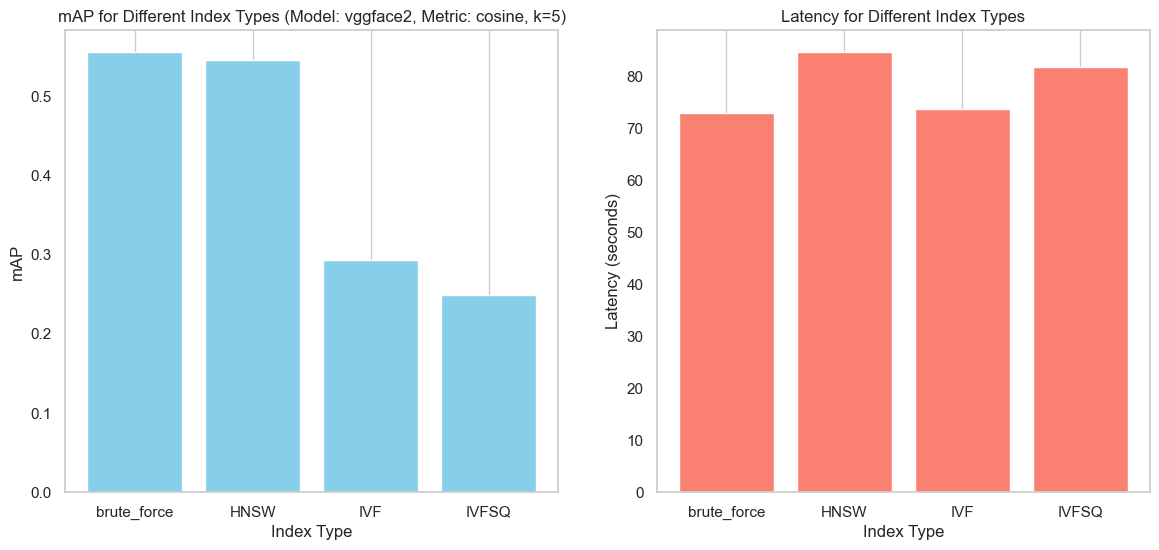

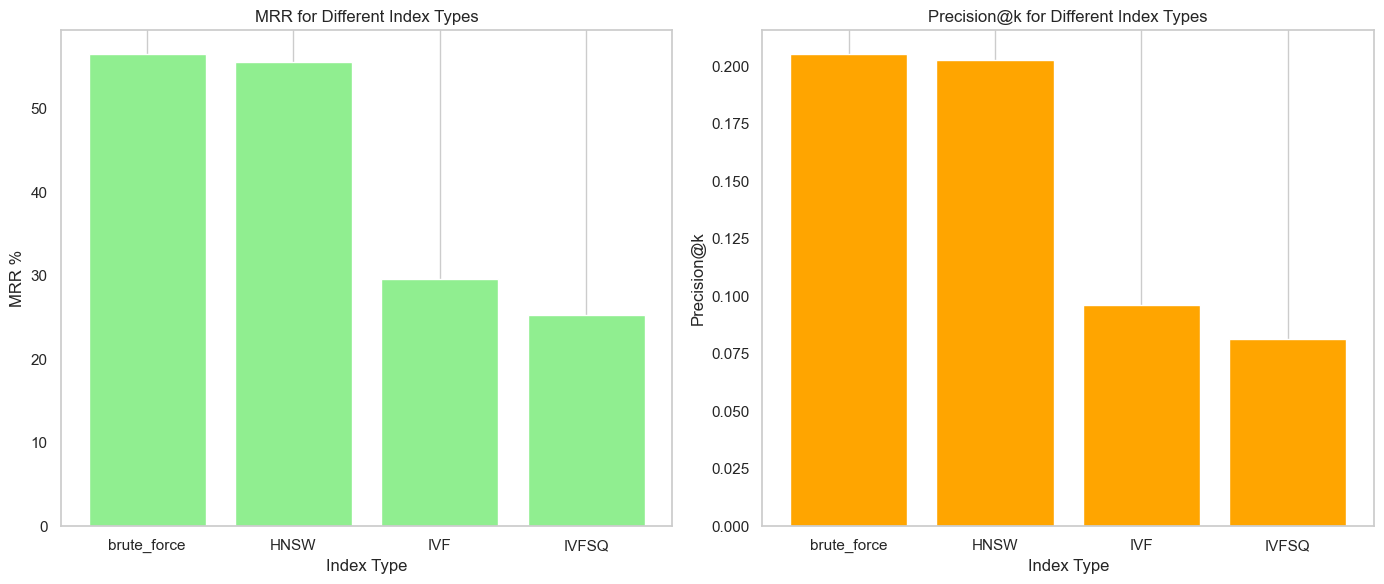

In [89]:
# Filter data for model 'vggface2', metric 'cosine', k=5, and varying index types
model = 'vggface2'
metric = 'cosine'
k_value = 5
index_types = ['brute_force', 'IVF', 'HNSW', 'IVFSQ']
filtered_data_metric_comparison = data[(data['model'] == model) & 
                                      (data['metric'] == metric) & 
                                      (data['k'] == k_value) &
                                      (data['index_type'].isin(index_types))
                                      ]

print("Filtered Data for Verification:")
print(filtered_data_metric_comparison[['index_type', 'latency', 'mrr', 'precision@k', 'mAP']])

# Plot mAP and latency for different index types
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.bar(filtered_data_metric_comparison['index_type'], filtered_data_metric_comparison['mAP'], color='skyblue')
plt.xlabel('Index Type')
plt.ylabel('mAP')
plt.title(f'mAP for Different Index Types (Model: {model}, Metric: {metric}, k={k_value})')
plt.grid(axis='y')

# Latency plot
plt.subplot(1, 2, 2)
plt.bar(filtered_data_metric_comparison['index_type'], filtered_data_metric_comparison['latency'], color='salmon')
plt.xlabel('Index Type')
plt.ylabel('Latency (seconds)')
plt.title('Latency for Different Index Types')
plt.grid(axis='y')

# Additional plot for mrr and precision@k
plt.figure(figsize=(14, 6))
# MRR plot
plt.subplot(1, 2, 1)
plt.bar(filtered_data_metric_comparison['index_type'], filtered_data_metric_comparison['mrr'], color='lightgreen')
plt.xlabel('Index Type')
plt.ylabel('MRR %')
plt.title('MRR for Different Index Types')
plt.grid(axis='y')

# Precision@k plot
plt.subplot(1, 2, 2)
plt.bar(filtered_data_metric_comparison['index_type'], filtered_data_metric_comparison['precision@k'], color='orange')
plt.xlabel('Index Type')
plt.ylabel('Precision@k')
plt.title('Precision@k for Different Index Types')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

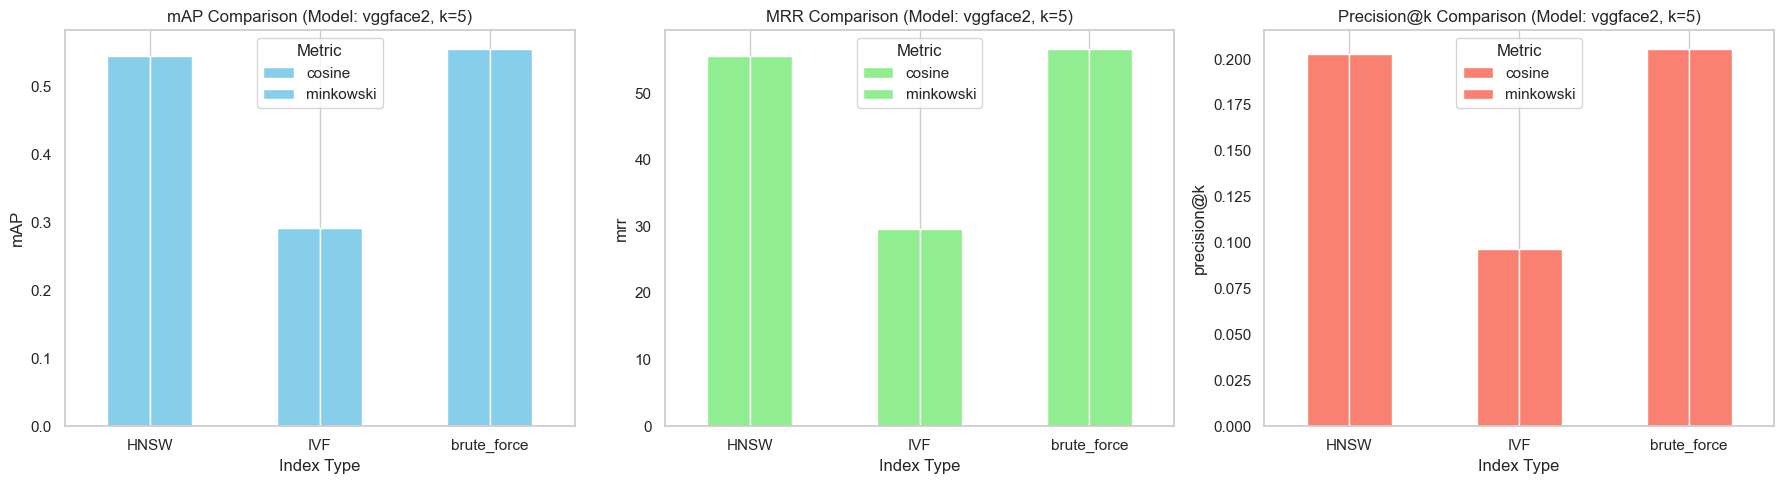

In [88]:
# Set up subplots for mAP, MRR, and Precision@k to compare impact of 'cosine' vs 'minkowski' metric
model = 'vggface2'
k_value = 5
index_types = ['brute_force', 'IVF', 'HNSW']
filtered_data_metric_comparison = data[(data['model'] == model) & 
                                       (data['k'] == k_value) & 
                                       (data['index_type'].isin(index_types))]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Define the metrics to plot
metrics_to_plot = ['mAP', 'mrr', 'precision@k']
titles = ['mAP', 'MRR', 'Precision@k']
colors = ['skyblue', 'lightgreen', 'salmon']

for i, metric in enumerate(metrics_to_plot):
    # Group data by index type and metric
    plot_data = filtered_data_metric_comparison.pivot(index='index_type', columns='metric', values=metric)
    
    # Plot each metric side-by-side for cosine and minkowski
    plot_data[['cosine', 'minkowski']].plot(kind='bar', ax=axs[i], color=colors[i])
    axs[i].set_xlabel('Index Type')
    axs[i].set_ylabel(metric)
    axs[i].set_title(f'{titles[i]} Comparison (Model: {model}, k={k_value})')
    axs[i].grid(axis='y')
    axs[i].legend(title='Metric')
    axs[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## Adding Noise Transformations

In [91]:
# Flip the image horizontally
def horizontal_flip(image):
    return cv2.flip(image, 1)

# Apply a Gaussian blur to smooth the image
def gaussian_blur(image, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma)

# Resize the image to the specified size
def resize(image, new_size):
    return cv2.resize(image, new_size)

# Crop the image to the specified size
def random_crop(image, crop_size):
    h, w = image.shape[:2]
    crop_h, crop_w = crop_size
    start_y = np.random.randint(0, h - crop_h + 1)
    start_x = np.random.randint(0, w - crop_w + 1)
    return image[start_y:start_y + crop_h, start_x:start_x + crop_w]

# Rotate the image by a given angle
def rotate(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

# Increase or decrease the brightness of the image
def adjust_brightness(image, value=30):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v, value)
    v = np.clip(v, 0, 255)
    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)


In [92]:
def apply_noise_transformations(image):
    """
    Apply various noise transformations to an image and return a dictionary 
    containing the transformed images.
    """
    # Define various severity levels for transformations
    severity_levels = {
        'blur': [(15, 15), (31, 31)],  # kernel sizes for Gaussian blur
        'brightness': [60, -60],     # brightness increase and decrease
        'rotate': [15, 45],     # degrees to rotate
        'crop_size': [(70, 70), (100, 100)]  # cropping sizes
    }
    
    # Store all transformed images in a dictionary
    transformed_images = {
        'original': image,
        'horizontal_flip': horizontal_flip(image),
        'gaussian_blur_light': gaussian_blur(image, severity_levels['blur'][0]),
        'gaussian_blur_strong': gaussian_blur(image, severity_levels['blur'][1]),
        'resize_small': resize(image, (128, 128)),
        'resize_large': resize(image, (256, 256)),
        'random_crop_small': random_crop(image, severity_levels['crop_size'][0]),
        'random_crop_large': random_crop(image, severity_levels['crop_size'][1]),
        'rotate_small': rotate(image, severity_levels['rotate'][0]),
        'rotate_large': rotate(image, severity_levels['rotate'][1]),
        'brightness_increase': adjust_brightness(image, severity_levels['brightness'][0]),
        'brightness_decrease': adjust_brightness(image, severity_levels['brightness'][1])
    }
    
    return transformed_images

In [65]:
def evaluate_transformed_images_mrr(probe_folder_path, pipeline, k=5):
    """
    Evaluate the Mean Reciprocal Rank (MRR) performance impacts of various noise transformations 
    on probe images.
    """
    total_mrr = {key: 0 for key in ['original', 'horizontal_flip', 'gaussian_blur_light', 'gaussian_blur_strong',
                                    'resize_small', 'resize_large', 'random_crop_small', 'random_crop_large',
                                    'rotate_small', 'rotate_large', 'brightness_increase', 'brightness_decrease']}
    
    total_probes = 0

    for probe_name in os.listdir(probe_folder_path):
        probe_person_folder = os.path.join(probe_folder_path, probe_name)

        for probe_file_name in os.listdir(probe_person_folder):
            if probe_file_name.endswith(('.jpg', '.png', '.jpeg')) and not probe_file_name.startswith('._'):
                image_path = os.path.join(probe_person_folder, probe_file_name)
                total_probes += 1

                try:
                    # Open the image
                    probe_image = Image.open(image_path)
                    probe_image_cv2 = np.array(probe_image)

                    # Apply noise transformations
                    transformed_images = apply_noise_transformations(probe_image_cv2)

                    # Evaluate for each transformation
                    for transform_name, transformed_image in transformed_images.items():
                        transformed_image_pil = Image.fromarray(transformed_image)
                        
                        # Get the top neighbors for the transformed probe image
                        results = pipeline.search_gallery(transformed_image_pil, k)

                        # Calculate Reciprocal Rank for the transformation
                        names = [result['name'] for result in results]
                        reciprocal_rank = 0

                        for i in range(k):
                            if probe_name == names[i][0]:
                                reciprocal_rank = 1 / (i + 1)
                                break 
                        
                        # Add reciprocal rank to total
                        total_mrr[transform_name] += reciprocal_rank

                except PIL.UnidentifiedImageError:
                    print(f"Skipping file {image_path}: UnidentifiedImageError")

    # Calculate the average MRR for each transformation
    for transform_name in total_mrr:
        avg_mrr = total_mrr[transform_name] / total_probes
        print(f"Transformation: {transform_name} | Mean Reciprocal Rank (MRR): {avg_mrr:.2f}")


In [66]:
evaluate_transformed_images_mrr(probe_folder_path, pipeline1, k=5)

Transformation: original | Mean Reciprocal Rank (MRR): 0.56
Transformation: horizontal_flip | Mean Reciprocal Rank (MRR): 0.54
Transformation: gaussian_blur_light | Mean Reciprocal Rank (MRR): 0.44
Transformation: gaussian_blur_strong | Mean Reciprocal Rank (MRR): 0.09
Transformation: resize_small | Mean Reciprocal Rank (MRR): 0.56
Transformation: resize_large | Mean Reciprocal Rank (MRR): 0.56
Transformation: random_crop_small | Mean Reciprocal Rank (MRR): 0.01
Transformation: random_crop_large | Mean Reciprocal Rank (MRR): 0.09
Transformation: rotate_small | Mean Reciprocal Rank (MRR): 0.47
Transformation: rotate_large | Mean Reciprocal Rank (MRR): 0.04
Transformation: brightness_increase | Mean Reciprocal Rank (MRR): 0.27
Transformation: brightness_decrease | Mean Reciprocal Rank (MRR): 0.19


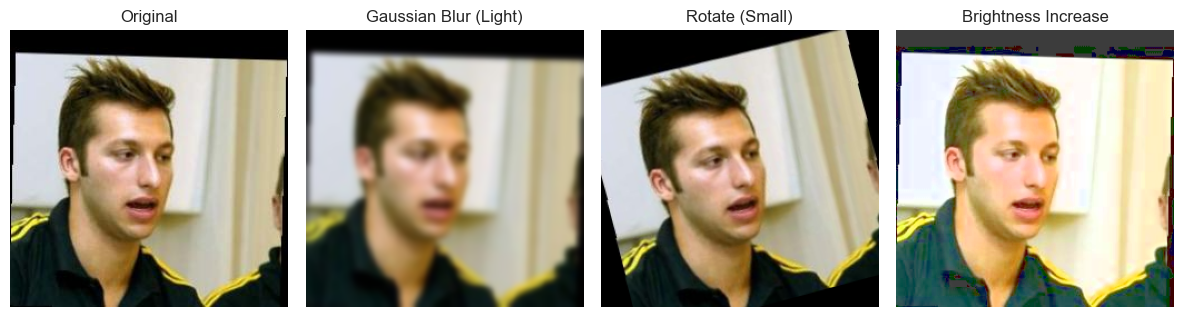

In [107]:
# Load the sample probe image
sample_probe = Image.open(sample_probe_path)

# Display the original and transformed sample probe
selected_transformations = ['original', 'gaussian_blur_light', 'rotate_small', 'brightness_increase']

# Prepare the images for display
images_to_display = [transformed_images[transformation] for transformation in selected_transformations]
titles = ["Original", "Gaussian Blur (Light)", "Rotate (Small)", "Brightness Increase"]

# Create a figure with subplots to display the images side by side
plt.figure(figsize=(12, 8))

for i, (image, title) in enumerate(zip(images_to_display, titles)):
    # Convert to PIL format if needed
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
        
    plt.subplot(1, 4, i + 1)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [113]:
# Define the correct name for comparison
correct_name = "Ian_Thorpe"

# Perform retrieval with the baseline (original image)
start_time = time.time()
baseline_results = pipeline1.search_gallery(sample_probe, k=5)
baseline_latency = time.time() - start_time

# Find rank of the correct name in baseline results
baseline_rank = next((i + 1 for i, result in enumerate(baseline_results) if result['name'][0] == correct_name), None)

# Store baseline results
results = {
    'baseline': {
        "top_k_results": baseline_results,
        "query_latency": baseline_latency,
        "correct_rank": baseline_rank
    }
}

# Convert the original image to a NumPy array for transformations
sample_probe_np = np.array(sample_probe)

# Apply transformations
transformed_images = apply_noise_transformations(sample_probe_np)

# Define a list of transformations to use (skip 'original' as it’s already done)
selected_transformations = ['gaussian_blur_light', 'rotate_small', 'brightness_increase']

# Perform retrieval for each selected transformation
for transformation in selected_transformations:
    transformed_image = transformed_images[transformation]

    # Convert the transformed image back to PIL format if it's in NumPy array format
    if isinstance(transformed_image, np.ndarray):
        transformed_image = Image.fromarray(transformed_image)

    start_time = time.time()
    retrieval_results = pipeline1.search_gallery(transformed_image, k=5)
    query_latency = time.time() - start_time

    # Find the rank of the correct name in the top-k results
    correct_rank = next((i + 1 for i, result in enumerate(retrieval_results) if result['name'][0] == correct_name), None)

    results[transformation] = {
        "top_k_results": retrieval_results,
        "query_latency": query_latency,
        "correct_rank": correct_rank
    }

# Display results and rank of correct name for each transformation
for key, value in results.items():
    print(f"Transformation: {key}")
    print(f"Query Latency: {value['query_latency']:.4f} seconds")
    print(f"Rank of Correct Name ('{correct_name}'): {value['correct_rank'] if value['correct_rank'] is not None else 'Not in top-k'}")
    print("Top-k Results:")
    for rank, result in enumerate(value["top_k_results"], start=1):
        print(f"Rank {rank}: Index: {result['index']}, Distance: {result['distance']:.4f}, Name: {result['name']}, Filename: {result['filename']}")
    print("\n" + "-"*50 + "\n")


Transformation: baseline
Query Latency: 0.0498 seconds
Rank of Correct Name ('Ian_Thorpe'): 1
Top-k Results:
Rank 1: Index: 872, Distance: 0.3585, Name: ['Ian_Thorpe'], Filename: ['Ian_Thorpe_0006.jpg']
Rank 2: Index: 1732, Distance: 0.3244, Name: ['Oscar_De_La_Hoya'], Filename: ['Oscar_De_La_Hoya_0003.jpg']
Rank 3: Index: 871, Distance: 0.2565, Name: ['Ian_Thorpe'], Filename: ['Ian_Thorpe_0005.jpg']
Rank 4: Index: 1716, Distance: 0.2039, Name: ['Noah_Wyle'], Filename: ['Noah_Wyle_0001.jpg']
Rank 5: Index: 1500, Distance: 0.1951, Name: ['Mark_Dacey'], Filename: ['Mark_Dacey_0001.jpg']

--------------------------------------------------

Transformation: gaussian_blur_light
Query Latency: 0.0321 seconds
Rank of Correct Name ('Ian_Thorpe'): 4
Top-k Results:
Rank 1: Index: 1732, Distance: 0.2553, Name: ['Oscar_De_La_Hoya'], Filename: ['Oscar_De_La_Hoya_0003.jpg']
Rank 2: Index: 195, Distance: 0.2333, Name: ['Bashar_Assad'], Filename: ['Bashar_Assad_0003.jpg']
Rank 3: Index: 1716, Distance:

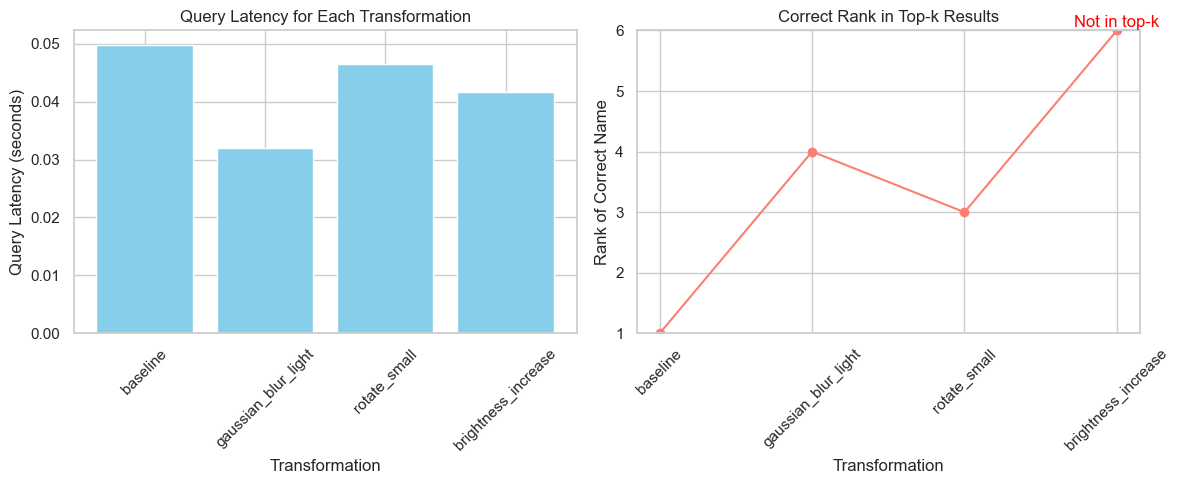

In [115]:
# Extract data from the results dictionary
transformations = list(results.keys())
latencies = [results[transformation]['query_latency'] for transformation in transformations]
correct_ranks = [results[transformation]['correct_rank'] if results[transformation]['correct_rank'] is not None else 6 for transformation in transformations]

# Plot query latency for each transformation
plt.figure(figsize=(12, 5))

# Latency bar chart
plt.subplot(1, 2, 1)
plt.bar(transformations, latencies, color='skyblue')
plt.xlabel('Transformation')
plt.ylabel('Query Latency (seconds)')
plt.title('Query Latency for Each Transformation')
plt.xticks(rotation=45)

# Correct Rank line plot
plt.subplot(1, 2, 2)
plt.plot(transformations, correct_ranks, marker='o', color='salmon', linestyle='-')
plt.xlabel('Transformation')
plt.ylabel('Rank of Correct Name')
plt.title('Correct Rank in Top-k Results')
plt.xticks(rotation=45)
plt.ylim(1, 6)  # Set y-axis limit to show rank 1-5, with 6 indicating "not in top-k"

# Annotate points where the correct name is "Not in top-k"
for i, rank in enumerate(correct_ranks):
    if rank == 6:
        plt.text(i, rank, 'Not in top-k', color='red', ha='center', va='bottom')

# Display the plots
plt.tight_layout()
plt.show()

**Summary of Effects:**
The system shows minimal sensitivity to horizontal flips and resizing, with slight degradation under small rotations and light blur. However, strong blur, large rotations, and significant brightness changes cause notable performance drops, especially in random crops, which severely impair accuracy.

**Design Thoughts:**
To improve robustness, the system should incorporate image preprocessing steps like face detection, alignment, and brightness normalization. Training with augmented data that includes small rotations, light blurs, and brightness variations can make the model more resilient. For extreme cases (e.g., strong blur or large rotation), the system could trigger a re-capture mechanism to ensure image quality.